#  Plot comparisons

* Should start to adopt postopus
* Time and N iterations 
* ~Rel density and total density

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


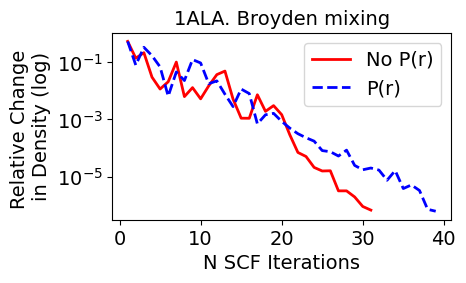

In [9]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict

%load_ext autoreload
%autoreload 2


def initialise_subplot(n_plots: int, n_cols: int):
    # Plot settings
    assert n_cols > 0, "Must have at least one column"
    n_rows = math.ceil(n_plots/ n_cols)

    # Calculate the aspect ratio of standard A4
    aspect_ratio = 297.0 / 210.0

    # Calculate the width of the figure in inches
    fig_width = 8.3  # A4 width in inches (approx)

    # Calculate the height of the figure in inches to maintain aspect ratio
    fig_height = fig_width / aspect_ratio * (n_rows / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    fig.set_tight_layout(True)
    
    # axs will annoyingly return as a 1D array
    if n_rows == 1:
        axs = np.reshape(axs, (1, n_cols))
    
    return fig, axs
    

def parse_convergence_calculations(subdirs: List[str]) -> dict:
    """
    
    Should combine the entries separately. See parse_wrapper
    Expect file  = "no_preconditioning/1ALA_broyden
    :param files: 
    :return: 
    """
    system_calcs = {}
    
    for subdir in map(Path, subdirs):
        if not subdir.is_dir():
            raise NotADirectoryError(f'Cannot find {subdir.as_posix()}')
        system_name, mixer = Path(subdir).name.split('_')
        data =np.loadtxt(Path(subdir, 'static/convergence'), skiprows=1)
        system_calcs[system_name] =  {'mixer': mixer, 'data': data[:, [0, 4]]}

    return system_calcs
        
    
def parse_wrapper(subdirectories: List[str]) -> Tuple[Dict[str, list], dict]:
    """

    :param subdirectories: Expect final subdirectories in which the calculations where performed i.e.'1ALA_broyden'
    :return: 
    """
    no_pre_sys_calcs: dict = parse_convergence_calculations([f'no_preconditioning/{s}' for s in subdirectories])
    pre_sys_calcs: dict = parse_convergence_calculations([f'preconditioning/{s}' for s in subdirectories])

    name = lambda s: s.split('_')[0]

    system_calcs = {name(s): [] for s in subdirectories}
    missing_calcs = {'preconditioned': [], 'no preconditioning': []}
    
    plot_opts1 = {'label': 'No P(r)',
                 'ls': '-',
                 'lw': 2,
                 'color': 'red',
                 }
    plot_opts2 = {'label': 'P(r)',
                 'ls': '--',
                 'lw': 2,
                 'color': 'blue',
                 }

    for subdir in subdirectories:
        system_name, mixer = subdir.split('_')
        
        try: 
            calculation = no_pre_sys_calcs[system_name]
            calculation.update({'preconditioning': False,
                                'xlabel': 'N SCF Iterations', 
                                'ylabel': 'Relative Change \nin Density (log)', 
                                'plot_options': plot_opts1
                                })
            system_calcs[system_name].append(calculation)
        except KeyError:
            missing_calcs['no preconditioning'].append(subdir)
            
        try: 
            calculation = pre_sys_calcs[system_name]
            calculation.update({'preconditioning': True,
                                'xlabel': 'N SCF Iterations', 
                                'ylabel': 'Relative Change \nin Density (log)', 
                                'plot_options': plot_opts2
                               })
            system_calcs[system_name].append(calculation)
        except KeyError:
            missing_calcs['preconditioning'].append(subdir)
        
    return system_calcs, missing_calcs
    

# Settings
systems = ['1ALA']
mixer = 'broyden'
n_cols = 2
common_settings = {'label_size': 14, 'font_size': 14, 'legend_fsize': 14}

# Parse data
subdirectories = [f'{system}_{mixer}' for system in systems]
system_calcs, missing_calcs = parse_wrapper(subdirectories)


# Plot data
n_rows = math.ceil(len(systems)/ n_cols)
fig, axes = initialise_subplot(len(subdirectories), n_cols=n_cols)

# Initialise counters
empty_lims = 0, 0
i_cmp = -1

map_index_to_name = {i: name for i, name in enumerate(system_calcs.keys())}

for i, j in itertools.product(range(n_rows), range(n_cols)):
    i_cmp += 1

    # Exit when last entry is reached.
    if i_cmp > len(system_calcs) - 1:
        empty_lims = i, j
        break

    # All calculations for ith system
    name = map_index_to_name[i_cmp]
    calculations = system_calcs[name]

    # Plot calculations for a given system
    for calc in calculations:
        data = calc.pop('data')
        axes[i, j].plot(data[:, 0], data[:, 1], **calc['plot_options'])

    # Scales
    axes[i, j].set_yscale('log')

    # Ticks
    axes[i, j].tick_params(axis='both', which='major', labelsize=common_settings['label_size'])
    axes[i, j].tick_params(axis='both', which='minor', labelsize=common_settings['label_size'])

    # Labels
    axes[i, j].set_xlabel(calc['xlabel'], fontsize=common_settings['font_size'])
    axes[i, j].set_ylabel(calc['ylabel'], fontsize=common_settings['font_size'])
    axes[i, j].legend(prop={'size': common_settings['legend_fsize']})
    axes[i, j].set_title(f'{name}. {mixer.capitalize()} mixing', fontsize=common_settings['font_size'])

# Remove any empty subplots
if empty_lims != (0, 0):
    for i, j in itertools.product(range(empty_lims[0], n_rows), range(empty_lims[1], n_cols)):
        axes[i, j].remove()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


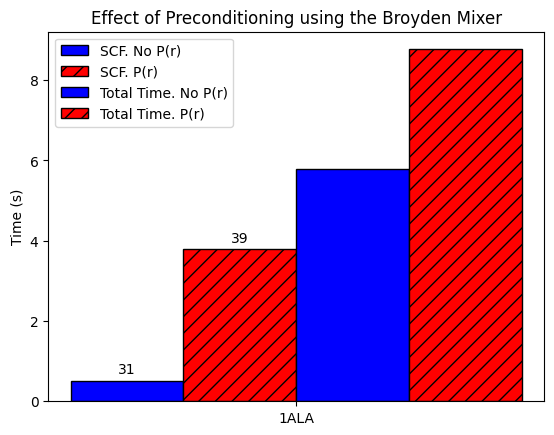

In [10]:
""" Note, it would be worth absorbing these into workflows, which work with Postopus
"""
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from typing import List

from oct_utils import parse_profiling, ConvergenceData


def bar_chart_data_single_field(files, field1: str, field2: str):
    """
    Return a single data field, for all systems
    :param files: 
    :return: 
    """
    values = []
    for file in files:
        data = parse_profiling(file)
        values.append(data['cumulative'][field1][field2])
    return values


def number_of_scf_iterations(files) -> List[int]:
    """ Wrapper util
    :param files: 
    :return: 
    """
    n_scf = []
    for file in files:
        convergence = ConvergenceData(file)
        n_scf.append(convergence.n_scf_iterations())
    return n_scf
    

def bar_plot(systems: List[str], fields: List[dict], width = 0.27, bar_labels=None, title=''):
    """ Plot several bar plots (one per field) for each system
    
    Adapted from this reference:
    https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
    
    :param systems: 
    :param fields: 
    :param width: 
    :return: 
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_dummy = np.arange(len(systems))  # the x locations for the systems
    ax.set_title(title)
    
    plots = []
    field_labels = []
    for i, field in enumerate(fields):
        data = field.pop('data')
        label = field.pop('label')
        # Plot a bar chart for single field, for all systems
        plot = ax.bar(x_dummy + (i * width), data, width, **field)
        plots.append(plot)
        field_labels.append(label)

    ax.set_ylabel('Time (s)')
    ax.set_xticks(x_dummy + ((len(fields) - 1) * 0.5 * width))
    ax.set_xticklabels(systems)
    ax.legend(plots, field_labels)

    if bar_labels is None:
        return
    
    # Add N SCF iterations as labels. Want plots 0 and 1
    for labels_for_field in bar_labels:
        ifield = labels_for_field['field']
        labels = labels_for_field['labels']
        assert len(labels) == len(systems)
        # For a given field, loop over each bar of the plot
        # i.e iterate over all systems contributing data to this field
        for i, bar in enumerate(plots[ifield]):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, labels[i], ha='center', va='bottom')


# SCF Time - no preconditioner
files = ['no_preconditioning/1ALA_broyden']
scf_no_pre_values = bar_chart_data_single_field(files, 'SCF_CYCLE', 'TOTAL_TIME')
# Total time - no preconditioner
total_no_pre_values = bar_chart_data_single_field(files, 'COMPLETE_RUN', 'TOTAL_TIME')
# Number of SCF iterations
nscf_no_pre = number_of_scf_iterations(files)

# SCF Time - Preconditioner
files = ['preconditioning/1ALA_broyden']
scf_pre_values = bar_chart_data_single_field(files, 'SCF_CYCLE', 'TOTAL_TIME')
# Total time - Preconditioner
total_pre_values = bar_chart_data_single_field(files, 'COMPLETE_RUN', 'TOTAL_TIME')
# Number of SCF iterations
nscf_pre = number_of_scf_iterations(files)


fields = [{'data': scf_no_pre_values, 'label': 'SCF. No P(r)', 'color': 'b', 'hatch': '', 'edgecolor': 'black'},
          {'data': scf_pre_values, 'label': 'SCF. P(r)', 'color': 'r', 'hatch': '//', 'edgecolor': 'black'},
          {'data': total_no_pre_values, 'label': 'Total Time. No P(r)', 'color': 'b', 'hatch': '', 'edgecolor': 'black'},
          {'data': total_pre_values, 'label': 'Total Time. P(r)', 'color': 'r', 'hatch': '//', 'edgecolor': 'black'}]


# Apply labels to bars, for the SCF fields
# where the field index is defined by the order in fields, above
bar_labels = [{'field': 0, 'labels': nscf_no_pre}, {'field': 1, 'labels': nscf_pre}]

systems = ['1ALA']
title = 'Effect of Preconditioning using the Broyden Mixer'
bar_plot(systems, fields, bar_labels=bar_labels, title=title)




In [2]:
""" Timings in Table Form

More stats of interest:
* | N SCF steps with P(r) | Converged with P(r) | N SCF steps without P(r) | Converged w/o P(r)
"""
import numpy as np
import pandas as pd

# 'cumulative' or 'self'
time_type = 'cumulative'
# Subdirectory names for calculations
systems = ['1ALA_broyden']

# Create List[dict] for pandas
entries = []
stats = {'scf w': [], 'scf w/o': []}

for system in systems:
    system_name, mixer = system.split('_')
    data_to_visualise = {'System': system_name, 'Mixer': mixer}
    
    data_no_pre = parse_profiling(f'no_preconditioning/{system}')[time_type]
    data_pre = parse_profiling(f'preconditioning/{system}')[time_type]
    
    # TODO(Alex) Add n-atoms
    data_to_visualise.update({'SCF time w/o P(r)':   data_no_pre['SCF_CYCLE']['TOTAL_TIME'],
                              'SCF time w P(r)':      data_pre['SCF_CYCLE']['TOTAL_TIME'],
                              'Total time w/o P(r)': data_no_pre['COMPLETE_RUN']['TOTAL_TIME'],
                              'Total time w P(r)':    data_pre['COMPLETE_RUN']['TOTAL_TIME'],
                              'SCF Faster with P(r)?': data_no_pre['SCF_CYCLE']['TOTAL_TIME'] > data_pre['SCF_CYCLE']['TOTAL_TIME']}
                             )
    entries.append(data_to_visualise)
    
    # Collect some data for stats
    stats['scf w/o'].append(data_no_pre['SCF_CYCLE']['TOTAL_TIME'])
    stats['scf w'].append(data_pre['SCF_CYCLE']['TOTAL_TIME'])

pd.set_option('display.width', 120)  # Set the overall display width w.r.t. n_characters
df = pd.DataFrame(entries)
print(df)
print()

# Compute some stats
print('Summary')
print('--------------')

n_entries = len(df)
speed_up = np.empty(shape=n_entries)
for i in range(n_entries):
    speed_up[i] = stats['scf w/o'][i] / stats['scf w'][i]

# Percentage that are slower, and by how much
slower = speed_up[speed_up < 1.]
if len(slower) == 0:
    print(f'{len(slower)} / {n_entries} have slower SCF time')
else:
    print(f'{len(slower)} / {n_entries} have slower SCF time, by an average of {np.mean(1. / slower)} x')

# Percentage that are faster, and by how much
faster = speed_up[speed_up >= 1.]
if len(faster) == 0:
    print(f'{len(faster)} / {n_entries} have faster SCF time')
else:
    print(f'{len(faster)} / {n_entries} have faster SCF time, by an average of {np.mean(faster)} x')





  System    Mixer  SCF time w/o P(r)  SCF time w P(r)  Total time w/o P(r)  Total time w P(r)  SCF Faster with P(r)?
0   1ALA  broyden           0.509039         3.794614             5.794115           8.767568                  False

Summary
--------------
1 / 1 have slower SCF time, by an average of 7.4544661607460325 x
0 / 1 have faster SCF time
